In [1]:
rm(list=ls())
gc()
setwd("/hpc/group/pbenfeylab/CheWei/")

used    (Mb) gc trigger (Mb) max used (Mb)
Ncells  622070 33.3 1353921    72.4 1075910  57.5
Vcells 1153590  8.9 8388608    64.0 1802277  13.8

In [2]:
as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
options(future.globals.maxSize = 600000 * 1024^2)

[1] 49839632

In [3]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(RColorBrewer))

In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/ch416/miniconda3/envs/seu3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-3    circlize_0.4.15       ComplexHeatmap_2.14.0
[4] dplyr_1.0.10          ggplot2_3.4.0         Seurat_3.1.5         

loaded via a namespace (and not attached):
  [1] nlme_3.1-161        tsne_0.1-3.1        matrixStats_0.63.0 
  [4] doPa

In [5]:
pp.genes <- as.character(read.table("./CW_data/escoring/Root_sc/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)

In [6]:
use.sample <- c('sc_12','dc1','dc2','sc_130','sc_134','sc_133','sc_137')

In [7]:
read_seu <- function(dir,sample.name) { 
  seu <- readRDS(dir) 
  seu@assays$spliced_RNA <- NULL
  seu@assays$spliced_SCT <- NULL
  seu@assays$unspliced_RNA <- NULL
  seu@assays$unspliced_SCT <- NULL
  return(seu)
}

list.filenames <- list.files(path = "./COPILOT_other_projects/to_be_integrate/",pattern=".rds$") %>% .[match(use.sample, gsub("_COPILOT.rds","",.))]

rc.list <- list()

for (i in 1:length(list.filenames))
{   print(i)
    rc.list[[i]]<-read_seu(dir = paste0("./COPILOT_other_projects/to_be_integrate/",list.filenames[i]), sample.name = use.sample[i])
    rc.list[[i]]$time.anno.Li <- gsub("_.*$","",rc.list[[i]]$time.celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^.*_","",rc.list[[i]]$time.celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Distal ","",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Proximal ","",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Metaxylem","Xylem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Protoxylem","Xylem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Protophloem","Phloem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Metaphloem & Companion Cell","Phloem",rc.list[[i]]$celltype.anno.Li)
    
}

names(rc.list) <- list.filenames %>% gsub("./COPILOT_other_projects/to_be_integrate/","",.)

#for (i in 1:length(list.filenames))
#{
#  rc.list[[i]]<- suppressWarnings(suppressMessages(UpdateSeuratObject(rc.list[[i]])))
#}

#for (i in 1:length(list.filenames))
#{
#  rc.list[[i]] <-  FindVariableFeatures(rc.list[[i]], selection.method = "vst", nfeatures = 2000)
#}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7


In [8]:
rc.list

$sc_12_COPILOT.rds
An object of class Seurat 
49648 features across 10293 samples within 2 assays 
Active assay: SCT (23357 features, 23357 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$dc1_COPILOT.rds
An object of class Seurat 
47748 features across 3378 samples within 2 assays 
Active assay: SCT (21818 features, 21818 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$dc2_COPILOT.rds
An object of class Seurat 
47752 features across 3283 samples within 2 assays 
Active assay: SCT (22007 features, 22007 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$sc_130_COPILOT.rds
An object of class Seurat 
47003 features across 6656 samples within 2 assays 
Active assay: SCT (21436 features, 21436 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$sc_134_COPILOT.rds
An object of class Seurat 
47767 features 

In [9]:
rc.features <- SelectIntegrationFeatures(object.list = rc.list, nfeatures = 25000)
length(rc.features)

[1] 19735

In [10]:
## Remove Cell type specific DE genes
#rc.features <- rc.features[-c(sort(match(de, rc.features)))]
rc.features <- rc.features[-c(grep("ATMG",rc.features),grep("ATCG",rc.features),sort(match(pp.genes, rc.features)))]
length(rc.features)

[1] 17332

In [11]:
rc.list <- PrepSCTIntegration(object.list = rc.list, anchor.features = rc.features, verbose = TRUE)

In [12]:
# Use sc_12 as reference
rc.anchors <- suppressMessages(FindIntegrationAnchors(object.list = rc.list, normalization.method = "SCT", 
    anchor.features = rc.features, verbose = TRUE, reference=1))

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [13]:
rc.integrated <- suppressMessages(IntegrateData(anchorset = rc.anchors, normalization.method = "SCT", verbose = TRUE))

Warning message:
“Adding a command log without an assay associated with it”


In [ ]:
rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)

In [ ]:
#rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, metric = "correlation", n.components = 3)
#rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 3)
#rc.integrated@reductions$umap_3D <- rc.integrated@reductions$umap
#rc.integrated <- suppressMessages(RunUMAP(rc.integrated, reduction = "pca", dims = 1:4))
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
rc.integrated@reductions$umap_2D <- rc.integrated@reductions$umap
rc.integrated <- suppressMessages(FindNeighbors(rc.integrated, reduction = "pca",dims = 1:50))
rc.integrated <- suppressMessages(FindClusters(rc.integrated, resolution = 0.5, algorithm = 3))

In [42]:
saveRDS(rc.integrated, file = "./scRNA-seq/Integrated_Objects/rc.integrated_7S_GL2_lines_seu3_20240129.rds")

In [7]:
rc.integrated <- readRDS("./scRNA-seq/Integrated_Objects/rc.integrated_7S_GL2_lines_seu3_20240129.rds")

In [26]:
length(rownames(rc.integrated))

[1] 17332

In [20]:
rc.integrated

An object of class Seurat 
71562 features across 41936 samples within 3 assays 
Active assay: integrated (17332 features, 17332 variable features)
 2 other assays present: RNA, SCT
 3 dimensional reductions calculated: pca, umap, umap_2D

## UMAP

In [22]:
#rc.integrated[["umap"]]@cell.embeddings[,1] <- rc.integrated[["umap"]]@cell.embeddings[,1]*-1
#rc.integrated[["umap"]]@cell.embeddings[,2] <- rc.integrated[["umap"]]@cell.embeddings[,2]*-1
u2 <- rc.integrated@reductions$umap@cell.embeddings[,1]
u1 <- rc.integrated@reductions$umap@cell.embeddings[,2]
rc.integrated@reductions$umap@cell.embeddings[,1] <- u1
rc.integrated@reductions$umap@cell.embeddings[,2] <- u2

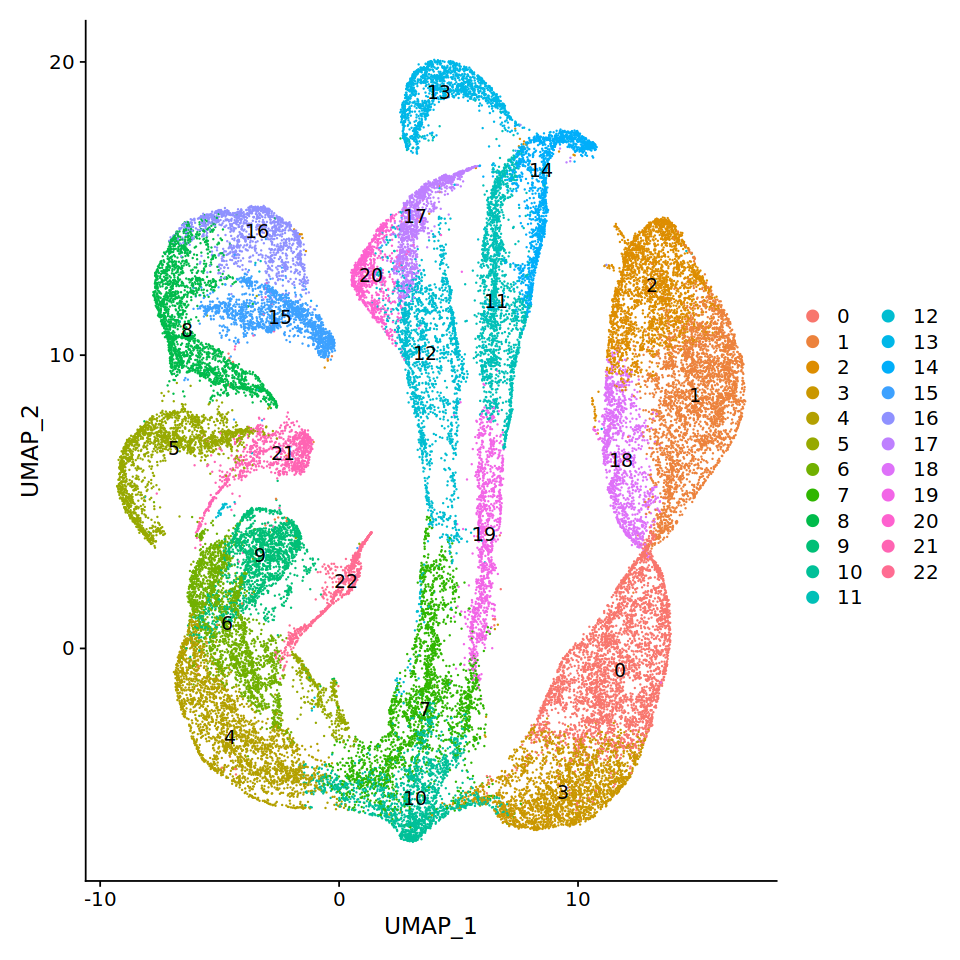

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "seurat_clusters", label = TRUE)

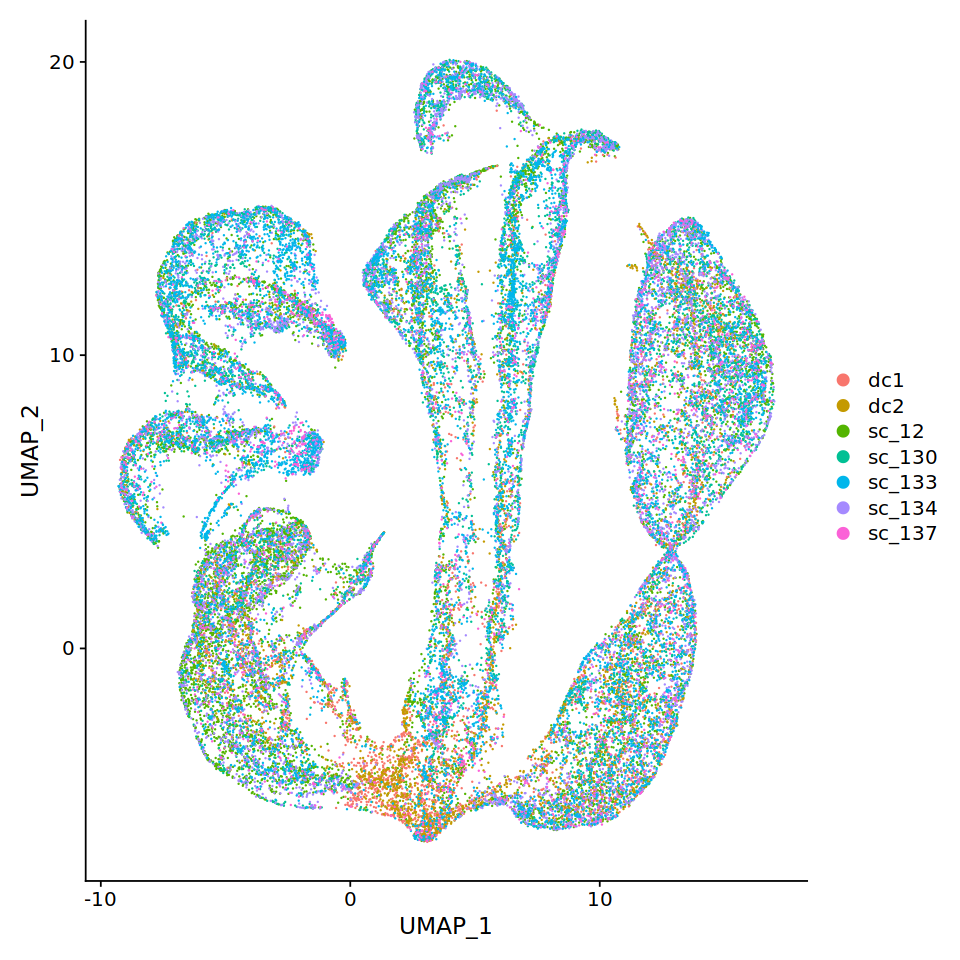

In [24]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "orig.ident", label = FALSE)

In [25]:
table(rc.integrated$orig.ident, rc.integrated$seurat_clusters)

        
            0    1    2    3    4    5    6    7    8    9   10   11   12   13
  dc1     462  206  177  301  115  158  183  540   72   76  504   94  128    5
  dc2     407  268  214  317  111  132  227  445   61   77  386   67  132    8
  sc_12   725  720  466  549 1043  618  857  289  470  839  298  350  339  349
  sc_130  320  757  547  208  204  336  171  196  489  210   80  388  392  424
  sc_133  805  489  346  449  311  493  328  449  630  161  282  596  442  218
  sc_134  575  633  681  438  453  428  391  171  336  385  163  227  278  465
  sc_137  159  200  141  120   96  123   79   96   83   71  104   71   58   51
        
           14   15   16   17   18   19   20   21   22
  dc1      37   12   15   29   72  130   25    2   35
  dc2      41   38    8   36   81  139   40    9   39
  sc_12   334  428  203  519  210  134  242   81  230
  sc_130  385  210  278  185  146  250  208  168  104
  sc_133  323  330  454  168  236  269  176  377   92
  sc_134  312  342  244  2

In [26]:
plot_anno <- function(rc.integrated){
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno.Li.crude <- factor(rc.integrated$celltype.anno.Li.crude, levels = order[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno.Li.crude", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno.Li.crude", order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B',"#deebf7", "#3182bd", '#fee0d2','#de2d26'))
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "consensus.time.group", cols=brewer.pal(10,"Spectral"))
p4 <- DimPlot(rc.integrated, reduction = "umap", group.by = "branch.anno")
options(repr.plot.width=16, repr.plot.height=12)
gl <- lapply(list(p1, p2, p3, p4), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}

In [27]:
prep <- function(seu){
seu$time.anno.Li.crude <- gsub("_.*$","",seu$time.celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Distal Columella","Distal Columella_Columella",seu$time.celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Distal Lateral Root Cap","Distal Lateral Root Cap_Lateral Root Cap",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Proximal Columella","Proximal Columella_Columella",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Proximal Lateral Root Cap","Proximal Lateral Root Cap_Lateral Root Cap",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("^.*_","",seu$celltype.anno.Li.crude)
    return(seu)
}

In [28]:
rc.integrated <- prep(rc.integrated)

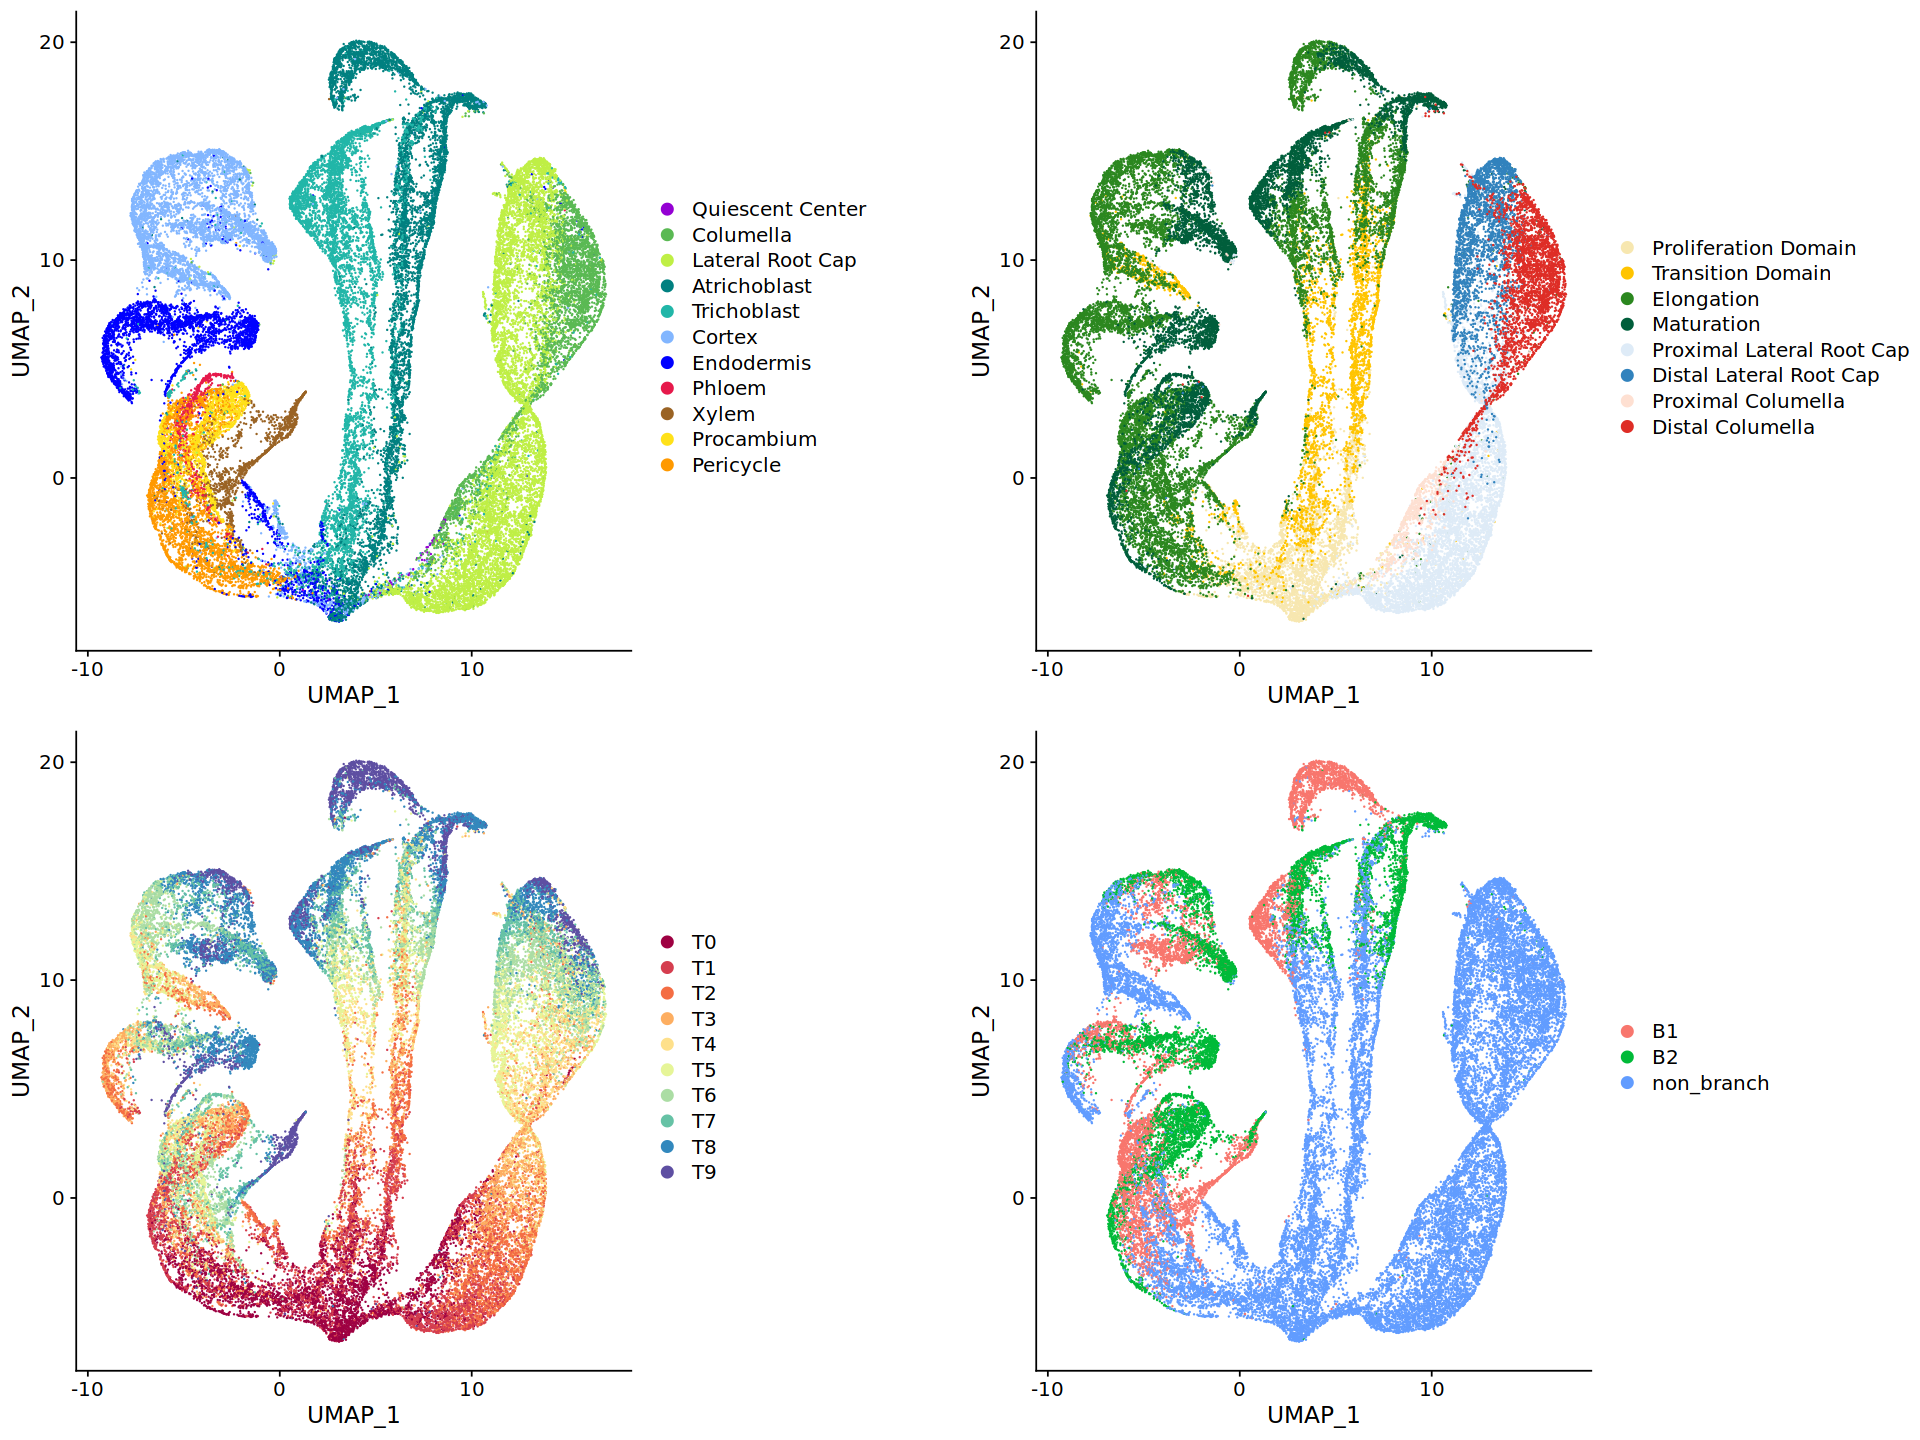

In [29]:
options(repr.plot.width=12, repr.plot.height=12)
plot_anno(rc.integrated)

In [30]:
DefaultAssay(rc.integrated) <- "SCT"

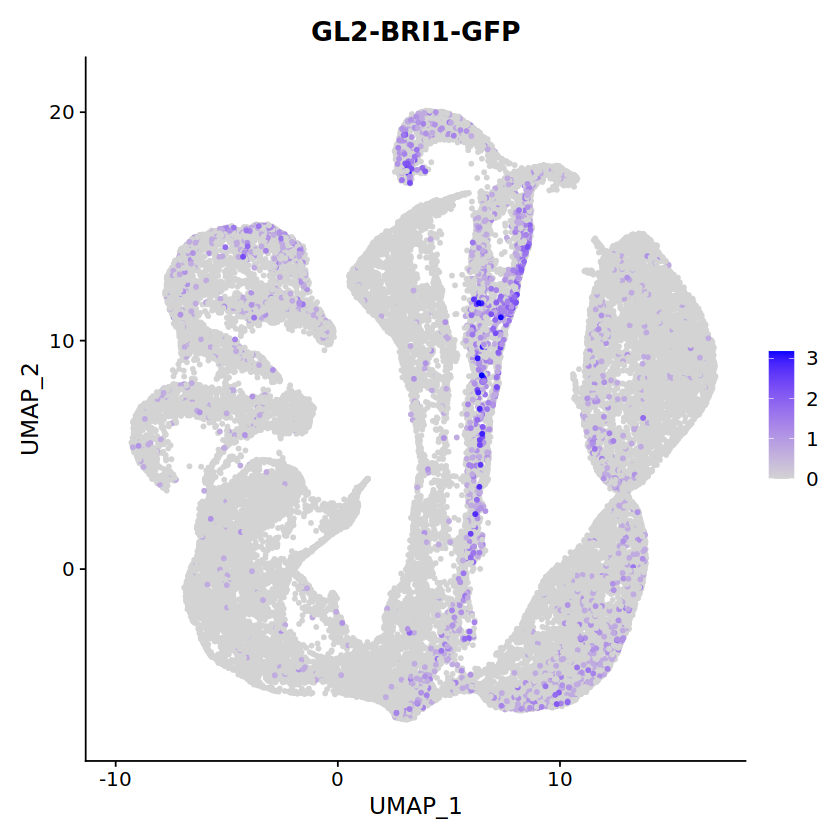

In [31]:
options(repr.plot.width=7, repr.plot.height=7)
FeaturePlot(rc.integrated, reduction = "umap", features = "GL2-BRI1-GFP", pt.size=1)

## Remove sc_12, dc1, dc2

In [32]:
rc.sub <- subset(rc.integrated, cells=colnames(rc.integrated)[rc.integrated$orig.ident %in% c("sc_130", "sc_133", "sc_134", "sc_137")])

In [33]:
rc.sub

An object of class Seurat 
71562 features across 24982 samples within 3 assays 
Active assay: SCT (24786 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

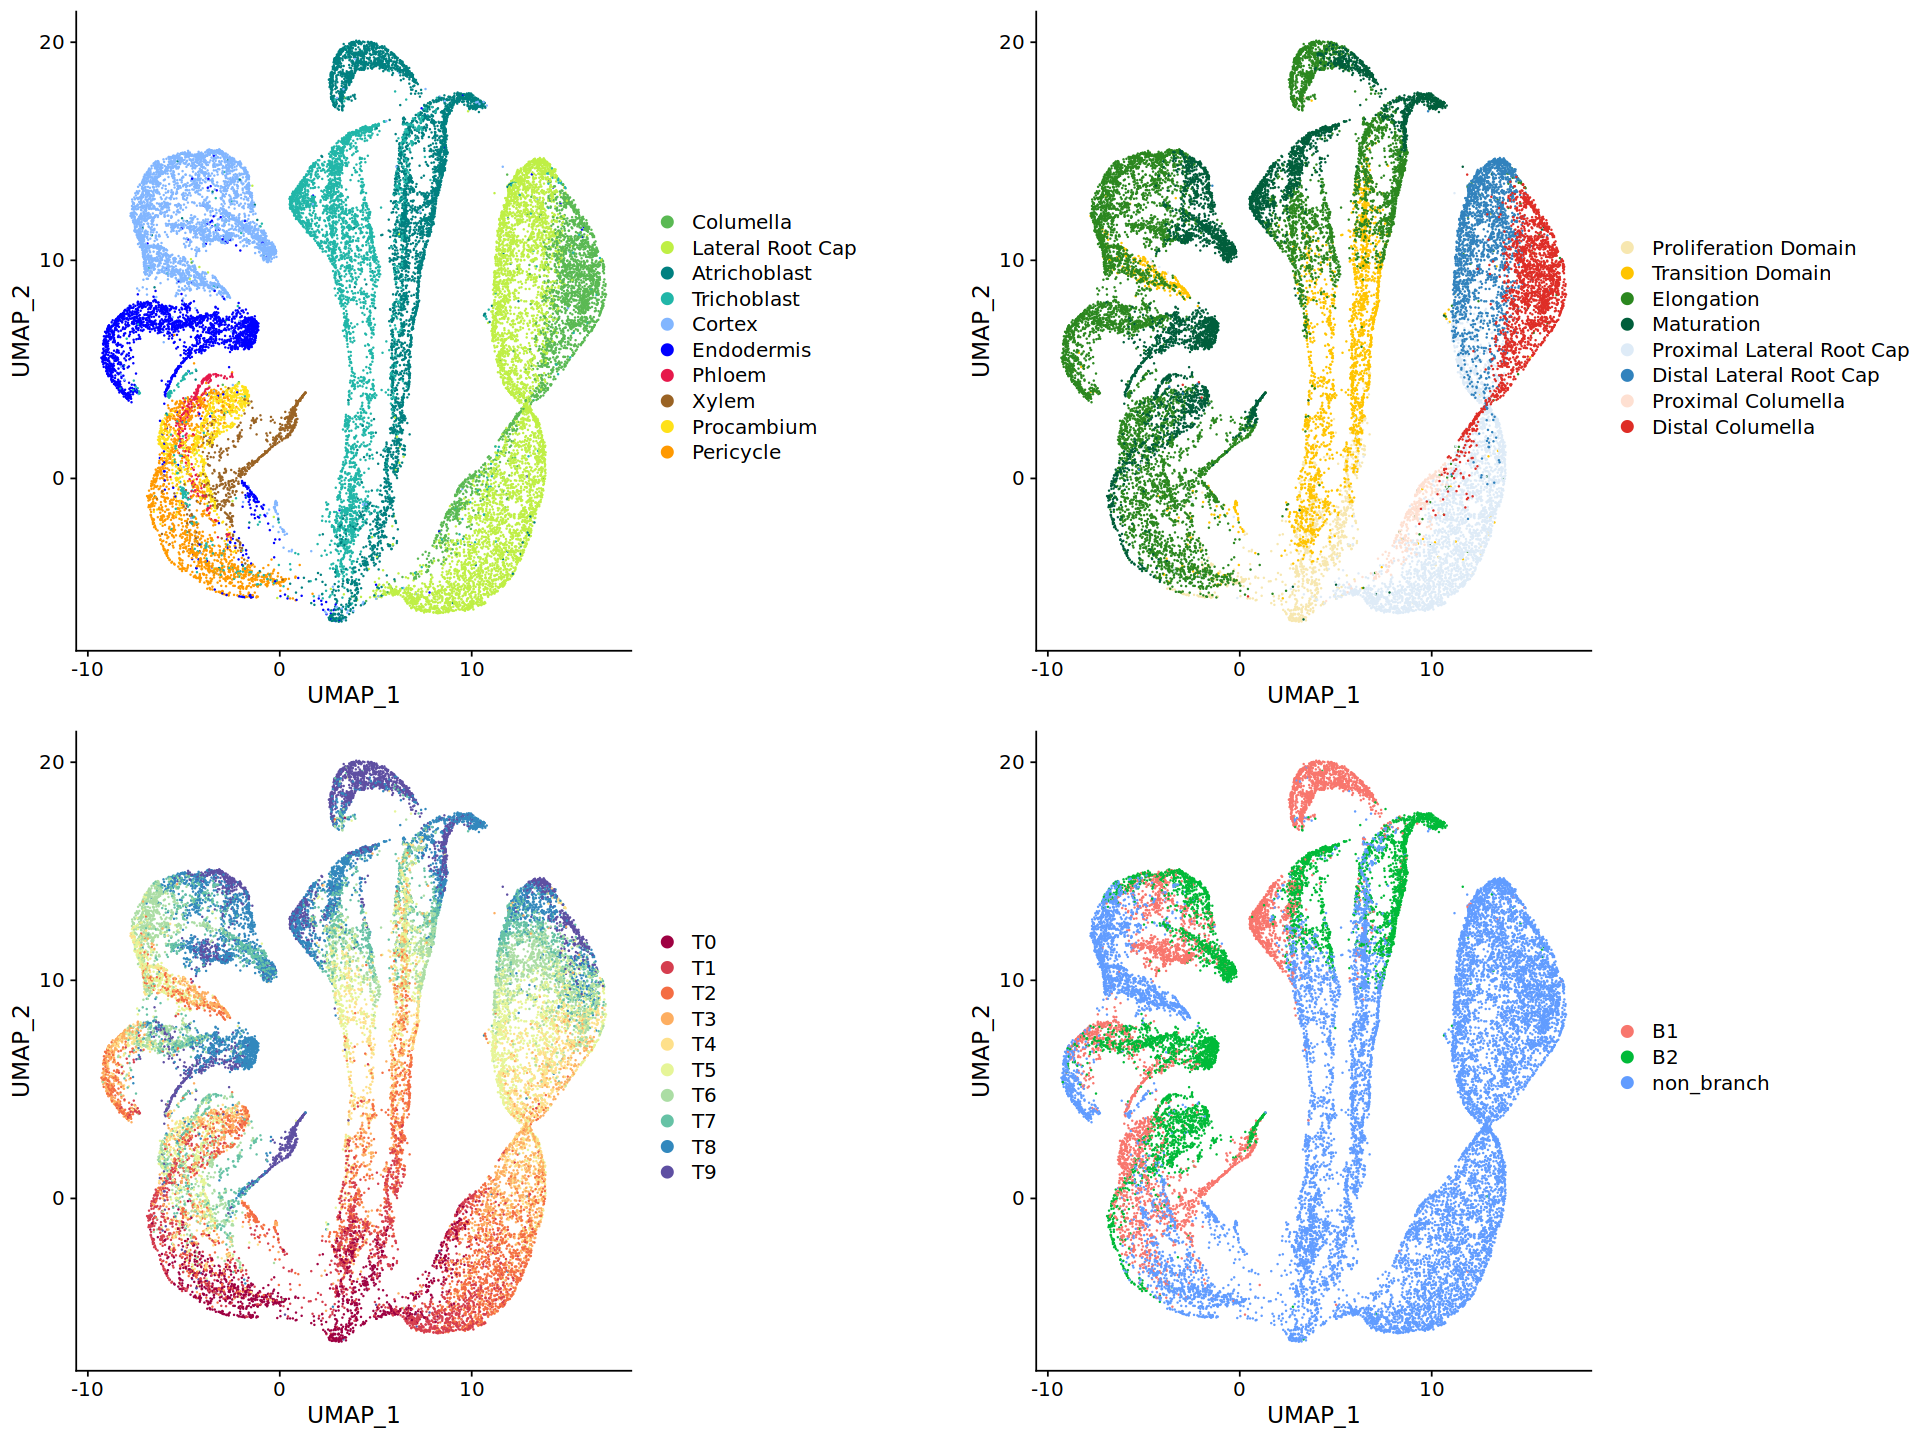

In [34]:
options(repr.plot.width=12, repr.plot.height=12)
plot_anno(rc.sub)

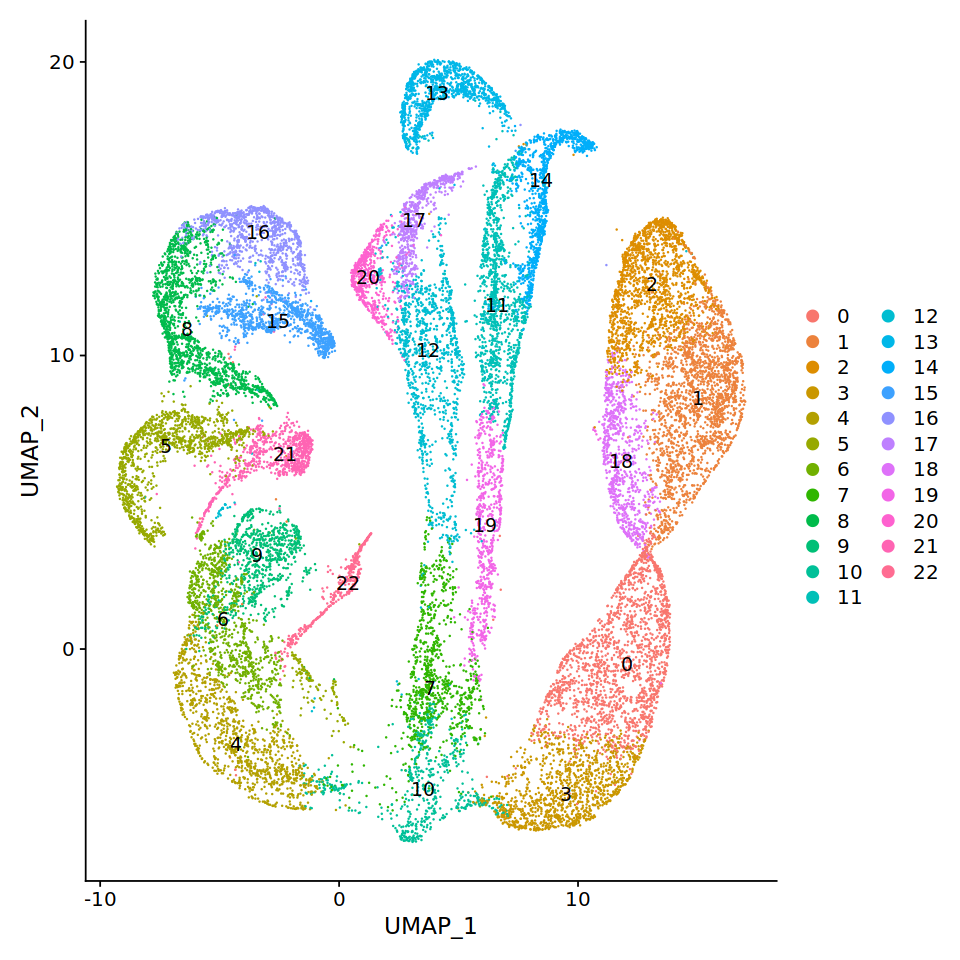

In [35]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.sub, reduction = "umap", group.by = "seurat_clusters", label = TRUE)

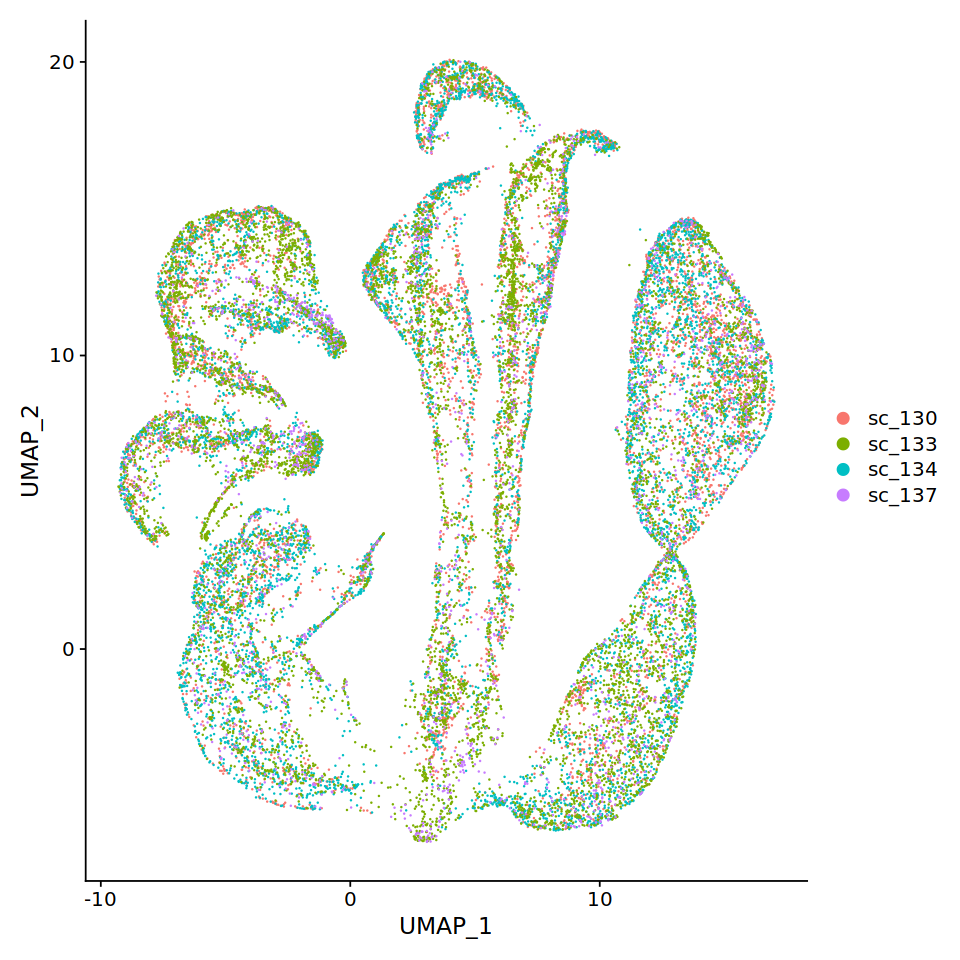

In [36]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.sub, reduction = "umap", group.by = "orig.ident", label = FALSE)

In [37]:
colnames(rc.sub@meta.data)

[1] "orig.ident"                                                       
  [2] "nCount_RNA"                                                       
  [3] "nFeature_RNA"                                                     
  [4] "nCount_spliced_RNA"                                               
  [5] "nFeature_spliced_RNA"                                             
  [6] "nCount_unspliced_RNA"                                             
  [7] "nFeature_unspliced_RNA"                                           
  [8] "percent.mt"                                                       
  [9] "percent.cp"                                                       
 [10] "nCount_SCT"                                                       
 [11] "nFeature_SCT"                                                     
 [12] "nCount_spliced_SCT"                                               
 [13] "nFeature_spliced_SCT"                                             
 [14] "nCount_unspliced_SCT"                                             
 [15] "nFeature_unspliced_SCT"                                           
 [16] "pANN_0.25_0.15_943"                                               
 [17] "DF.classifications_0.25_0.15_943"                                 
 [18] "celltype.ID"                                                      
 [19] "timezone.ID"                                                      
 [20] "celltype.cor"                                                     
 [21] "timezone.cor"                                                     
 [22] "celltype.pvalue"                                                  
 [23] "timezone.pvalue"                                                  
 [24] "celltype.ID.P"                                                    
 [25] "timezone.ID.P"                                                    
 [26] "celltype.cor.P"                                                   
 [27] "timezone.cor.P"                                                   
 [28] "celltype.pvalue.P"                                                
 [29] "timezone.pvalue.P"                                                
 [30] "Rad.ID"                                                           
 [31] "Long.ID"                                                          
 [32] "Rad.cor"                                                          
 [33] "Long.cor"                                                         
 [34] "Rad.pvalue"                                                       
 [35] "Long.pvalue"                                                      
 [36] "Rad.ID.P"                                                         
 [37] "Long.ID.P"                                                        
 [38] "Rad.cor.P"                                                        
 [39] "Long.cor.P"                                                       
 [40] "Rad.pvalue.P"                                                     
 [41] "Long.pvalue.P"                                                    
 [42] "SCT_snn_res.5"                                                    
 [43] "seurat_clusters"                                                  
 [44] "seucluster.celltype.cor"                                          
 [45] "seucluster.celltype.pvalue"                                       
 [46] "seucluster.celltype.ID"                                           
 [47] "seucluster.celltype.cor.P"                                        
 [48] "seucluster.celltype.pvalue.P"                                     
 [49] "seucluster.celltype.ID.P"                                         
 [50] "seucluster.timezone.cor"                                          
 [51] "seucluster.timezone.pvalue"                                       
 [52] "seucluster.timezone.ID"                                           
 [53] "seucluster.timezone.cor.P"                                        
 [54] "seucluster.timezone.pvalue.P"                                     
 [55] 

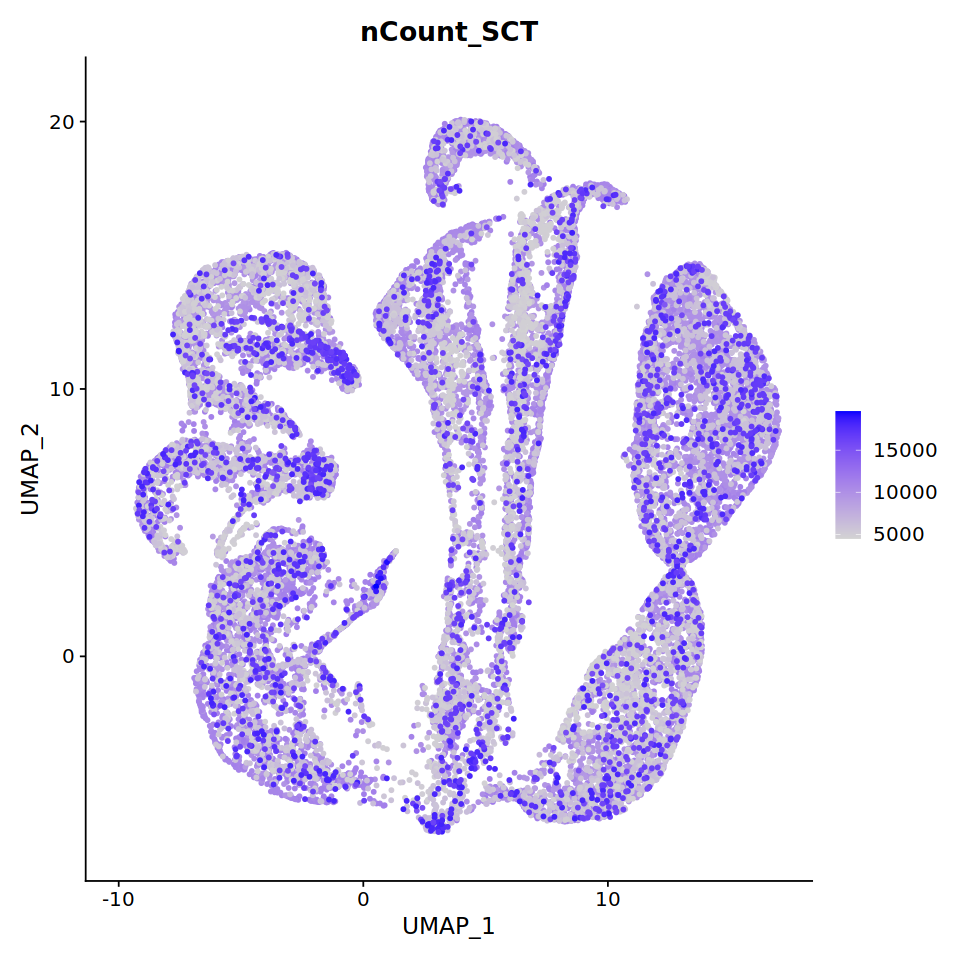

In [38]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(rc.sub, reduction = "umap", features = "nCount_SCT", pt.size=1)

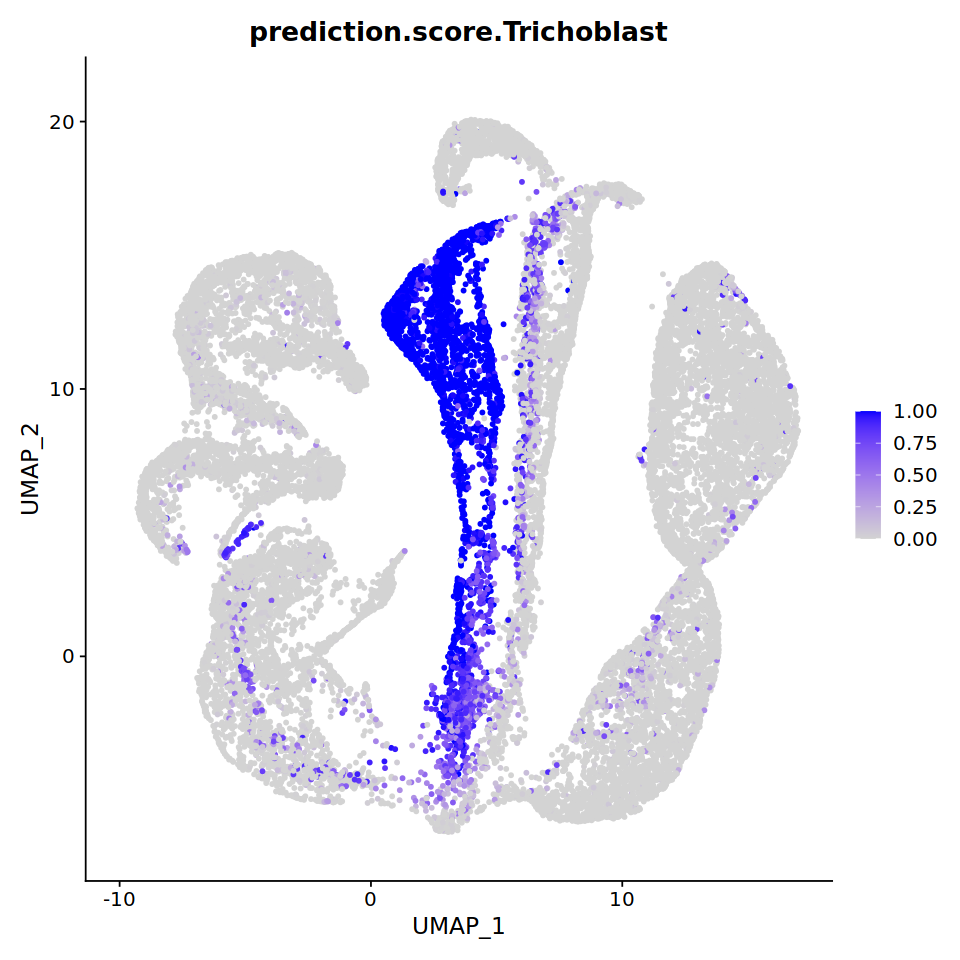

In [39]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(rc.sub, reduction = "umap", features = "prediction.score.Trichoblast", pt.size=1)

In [40]:
Idents(rc.sub) <- rc.sub$celltype.anno.Li.crude

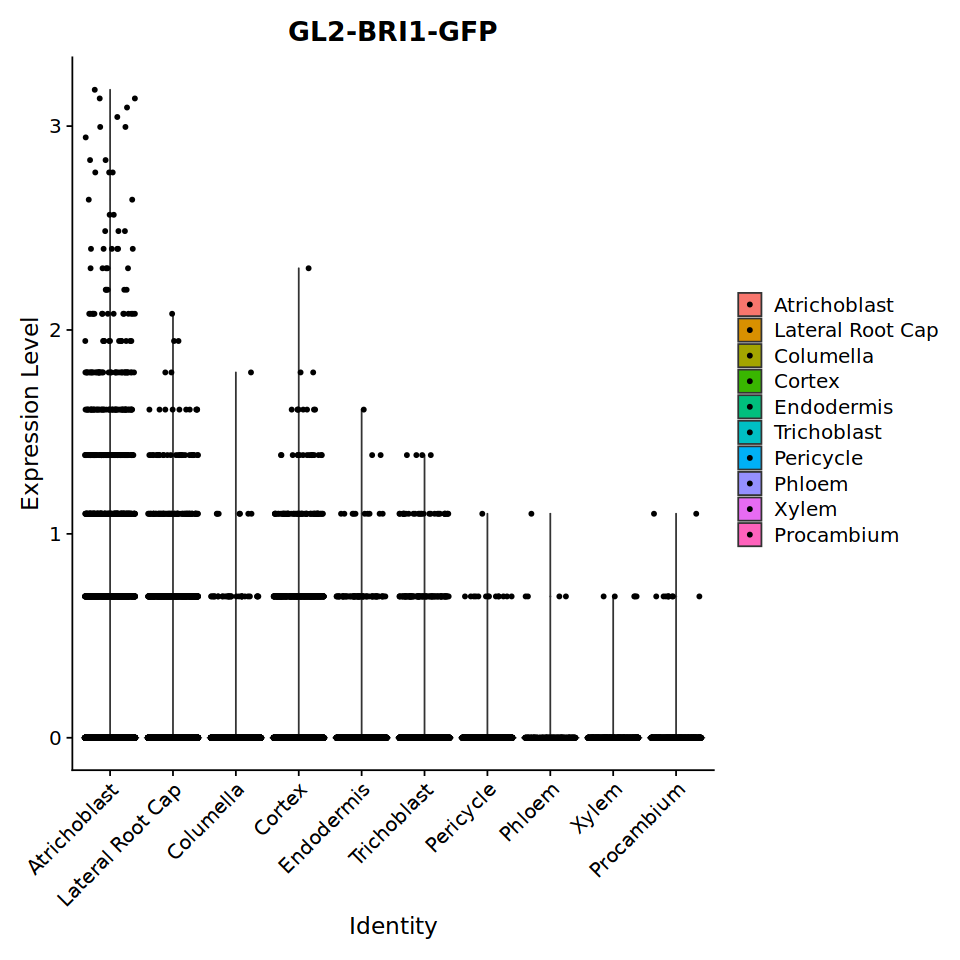

In [41]:
options(repr.plot.width=8, repr.plot.height=8)
# you can plot raw counts as well
VlnPlot(rc.sub, features = c("GL2-BRI1-GFP"), slot="data")

In [43]:
saveRDS(rc.sub, file = "./scRNA-seq/Integrated_Objects/rc.integrated_4S_GL2_lines_seu3_20240129.rds")